In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio
import math
import sys
from matplotlib.patches import Polygon

from LST import LST
from Node import Node
from units import mm, cm, m, kgf, N, tf, kN, MPa, GPa
from fem import Material, Membrane
from functions import matrix_extract,  get_nodes_from_physical_id, get_line_load_global_vector, matrix_replace


In [2]:
output_file= "mallas/malla_LST.msh"

In [3]:
ASTM_36 = Material.Material(name="ASTM 36", E=200.0 * GPa, nu=0.30, rho=7850 * kgf / (m**3))
Sup1 = Membrane.Membrane(name="Steel", thickness=2 * cm, material=ASTM_36)
Sup2 = Membrane.Membrane(name="Steel", thickness=2 * cm, material=ASTM_36)
section_dict = {"Steel1": Sup1, "Steel2":Sup2}

In [4]:
mesh = meshio.read(output_file)

# Asociación de tag físico con nombre
tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}

# Diccionario {nombre_grupo: [Node, Node, ...]}
grupos = {}
Materials = {}
# Procesar elementos tipo triangle
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "triangle6":
        continue
    for tri, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")

        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in tri:
            x, y = mesh.points[node_id][:2]
            grupos[nombre].append(Node(node_id+1, (x, y)))


# Procesar elementos tipo line (para grupos como "Fuerza")
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "line3":
        continue
    for line, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in line:
            x, y = mesh.points[node_id][:2]
            restrain = ["f", "f"]
            if nombre in ["BC_R1"]:
                restrain = ["r", "r"]
            grupos[nombre].append(Node(node_id+1, (x, y), restrain=restrain))
# Eliminar nodos duplicados por grupo
for nombre in grupos:
    nodos_unicos = {}
    for n in grupos[nombre]:
        nodos_unicos[n.name] = n
    grupos[nombre] = list(nodos_unicos.values())
    print(f"Grupo {nombre} - Cantidad de nodos: {len(grupos[nombre])}")
nodes_dict = {}
for group in grupos:
    for node in grupos[group]:
        nodes_dict[node.name] = node




Grupo Steel1 - Cantidad de nodos: 703
Grupo Steel2 - Cantidad de nodos: 703
Grupo BC_1 - Cantidad de nodos: 37
Grupo BC_R1 - Cantidad de nodos: 19


In [5]:
# Procesando los elementos de tipo "triangle6" (con 6 nodos)
triangles = mesh.cells_dict['triangle6']  # Obtiene los elementos de tipo 'triangle6'
tags = mesh.cell_data_dict["gmsh:physical"]["triangle6"]  # Obtiene las etiquetas de los elementos
elements = []  # Lista para almacenar los elementos procesados
nodes = set()  # Conjunto para almacenar los nodos únicos
print(f"Cantidad de triángulos: {len(tags)}")

# Recorremos los triángulos
for i in range(len(tags)):
    tag = tags[i]
    group_name = tag_to_name.get(tag, f"{tag}")  # Obtener el nombre del grupo

    # Verificar si el material está en section_dict
    if group_name not in section_dict:
        print(f"Advertencia: El material '{group_name}' no se encuentra en section_dict.")
        continue  # O usar un valor por defecto si es necesario

    material = section_dict[group_name]  # Obtener el material correspondiente

    node_ids = triangles[i]  # Obtener los IDs de los nodos para este elemento
    
    # Verificar que los nodos sean válidos
    print(f"Recuperando nodos para el triángulo {i+1} con ids: {node_ids}")
    
    # Comprobamos si los nodos existen en el diccionario
    try:
        nodo_a = nodes_dict.get(node_ids[0]+1)
        nodo_b = nodes_dict.get(node_ids[1]+1)
        nodo_c = nodes_dict.get(node_ids[2]+1)
        nodo_d = nodes_dict.get(node_ids[3]+1)
        nodo_e = nodes_dict.get(node_ids[4]+1)
        nodo_f = nodes_dict.get(node_ids[5]+1)
    except KeyError as e:
        print(f"Error recuperando nodos: {e}")
        continue  # Saltar al siguiente triángulo si hay un problema con los nodos

    # Si todos los nodos son válidos, procedemos
    for nodo in [nodo_a, nodo_b, nodo_c, nodo_d, nodo_e, nodo_f]:
        nodes.add(nodo)

    # Crear la lista de nodos (usando todos los nodos del triángulo)
    elem = [nodo_a, nodo_b, nodo_c, nodo_d, nodo_e, nodo_f]
    print(f"Triángulo {i+1} - Nodos: {[n.name for n in elem]} - Material: {material.name}")

    # Si los nodos fueron reordenados correctamente, crear el objeto LST
    if elem:
        element = LST(i + 1, elem, section=material)
        print(f"Elemento {element.element_tag} - Nodos: {[n.name for n in element.nodes]} - Material: {element.section.name}")
        elements.append(element)
        print(f"Elemento {i+1} procesado correctamente.")

# Convertir el conjunto de nodos a una lista
nodes = list(nodes)

Cantidad de triángulos: 648
Recuperando nodos para el triángulo 1 con ids: [  0   9 162  17 277 170]
Triángulo 1 - Nodos: [np.int32(1), np.int32(10), np.int32(163), np.int32(18), np.int32(278), np.int32(171)] - Material: Steel
Elemento 1 - Nodos: [np.int32(1), np.int32(10), np.int32(163), np.int32(18), np.int32(278), np.int32(171)] - Material: Steel
Elemento 1 procesado correctamente.
Recuperando nodos para el triángulo 2 con ids: [162   9 213 277 278 279]
Triángulo 2 - Nodos: [np.int32(163), np.int32(10), np.int32(214), np.int32(278), np.int32(279), np.int32(280)] - Material: Steel
Elemento 2 - Nodos: [np.int32(163), np.int32(10), np.int32(214), np.int32(278), np.int32(279), np.int32(280)] - Material: Steel
Elemento 2 procesado correctamente.
Recuperando nodos para el triángulo 3 con ids: [162 213 163 279 280 171]
Triángulo 3 - Nodos: [np.int32(163), np.int32(214), np.int32(164), np.int32(280), np.int32(281), np.int32(172)] - Material: Steel
Elemento 3 - Nodos: [np.int32(163), np.int3

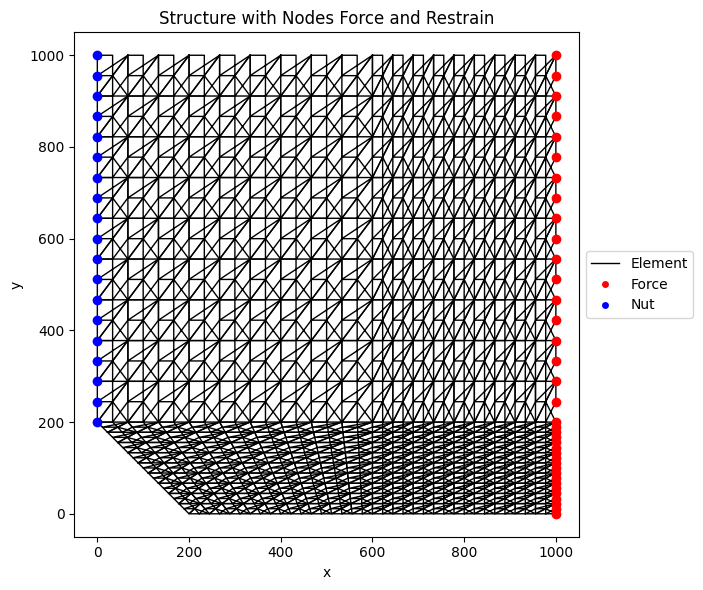

In [6]:

node_index_map = {node.name: i for i, node in enumerate(nodes)}
# Datos para el gráfico
# Datos para el gráfico
x = np.array([node.coordenadas[0] for node in nodes])  # Coordenadas X
y = np.array([node.coordenadas[1] for node in nodes])  # Coordenadas Y

# Gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Dibujar los elementos LST (líneas entre los nodos de cada elemento)
for elem in elements:
    coords = np.array([[node.coordenadas[0], node.coordenadas[1]] for node in elem.nodes])
    coords = np.vstack([coords, coords[0]])  # Cerrar el triángulo
    ax.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)  # Dibujar el triángulo en negro

# Dibujar nodos del grupo "Force" (en rojo)
for i, node in enumerate(grupos["BC_1"]):
    idx = node_index_map[node.name]
    ax.plot(x[idx], y[idx], 'ro', markersize=6, label="Carga (Force)" if i == 0 else "")

# Dibujar nodos del grupo "Nut" (en azul)
for i, node in enumerate(grupos["BC_R1"]):
    idx = node_index_map[node.name]
    ax.plot(x[idx], y[idx], 'bo', markersize=6, label="Apoyo" if i == 0 else "")

# Gráfico final
ax.set_title("Structure with Nodes Force and Restrain")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")

# Leyenda
ax.legend(
    handles=[
        plt.Line2D([0], [0], color='k', lw=1, label='Element'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=6, label='Force'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=6, label='Nut')
    ],
    loc="center left",
    bbox_to_anchor=(1.0, 0.5)  # Poner la leyenda fuera del gráfico
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajustar el diseño
plt.show()

In [7]:
def solve(nodes, elements):
    """
    Resuelve el sistema FEM considerando cargas distribuidas en líneas.
    
    Args:
        nodes (list): Lista de nodos con .idx, .nodalLoad, .restrain
        elements (list): Lista de elementos con .kg, .idx

    Returns:
        u (np.ndarray): Desplazamientos globales
        F_reactions (np.ndarray): Reacciones en DOFs restringidos
        Fj (np.ndarray): Fuerzas nodales aplicadas
        F_total (np.ndarray): Fuerzas totales incluyendo reacciones
    """
    
    nNodes = len(nodes)
    system_nDof = 2 * nNodes  # 2 DOFs por nodo
    
    # === CARGAS DISTRIBUIDAS EN LÍNEAS ===
    F_line_global = np.zeros(system_nDof)
    Fj = np.zeros(system_nDof)
    
    # Asignación de cargas nodales a las fuerzas aplicadas
    for node in nodes:
        for dof_idx, force in zip(node.idx, node.nodalLoad):
            if dof_idx >= system_nDof:
                print(f"Error: índice {dof_idx} fuera de rango para el nodo {node.name}")
                continue
            Fj[dof_idx] = force

    # === MATRIZ DE RIGIDEZ GLOBAL ===
    Kg = np.zeros((system_nDof, system_nDof))
    
    # Ensamblaje de la matriz de rigidez global
    for element in elements:
        try:
            Kg = matrix_replace(Kg, element.kg, element.idx, element.idx)
        except IndexError as e:
            print(f"Error al reemplazar en la matriz de rigidez global para el elemento {element.element_tag}.")
            print(f"Índices de DOF: {element.idx}")
            print(f"Error: {e}")
            continue  # Si ocurre un error, saltar al siguiente elemento
    
    # === RESTRICCIONES ===
    nodeIndex = np.full(system_nDof, '', dtype=str)
    for node in nodes:
        for dof_idx, status in zip(node.idx, node.restrain):
            nodeIndex[dof_idx] = status
    
    freeIndices = np.where(nodeIndex == 'f')[0]  # Índices de grados de libertad libres
    restrainedIndices = np.where(nodeIndex == 'r')[0]  # Índices de grados de libertad restringidos
    
    # === PARTICIÓN DEL SISTEMA ===
    Kff = matrix_extract(Kg, freeIndices, freeIndices)
    Kfr = matrix_extract(Kg, freeIndices, restrainedIndices)
    Krf = matrix_extract(Kg, restrainedIndices, freeIndices)
    Krr = matrix_extract(Kg, restrainedIndices, restrainedIndices)

    # === FUERZA TOTAL (aplicada + distribuida) ===
    F = Fj + F_line_global
    Ff = F[freeIndices]
    Fr = F[restrainedIndices]

    # === SOLUCIÓN ===
    # Resolución del sistema para desplazamientos libres
    uf = np.linalg.solve(Kff, Ff - Kfr @ Fr)
    
    ur = np.zeros(len(restrainedIndices))  # Desplazamientos restringidos son cero
    u = np.zeros(system_nDof)  # Desplazamientos globales
    u[freeIndices] = uf
    u[restrainedIndices] = ur

    # === REACCIONES ===
    Fr = Krf @ uf + Krr @ ur
    F_reactions = np.zeros(system_nDof)  # Fuerzas de reacción
    F_reactions[restrainedIndices] = Fr

    return u, F_reactions, Fj, F


De aquí para abajo empieza la configuración de las fuerzas:

1er caso: Fuerza distribuida

2do caso: Fuerza puntual

3er caso: Fuerza distribuida con peso propio

Primer Caso: Fuerza distribuida

In [8]:
def apply_distributed_force(grupo_nodos, fuerza_total_y):
    """
    Aplica una fuerza distribuida vertical (por ejemplo, peso) sobre una línea formada por nodos no alineados.
    La fuerza se reparte proporcionalmente a la longitud de los tramos y se descompone en x e y.
    """

    # Paso 1: ordena nodos si es necesario (aquí asumimos que ya están ordenados)
    nodos = grupo_nodos
    n = len(nodos)
    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Paso 2: calcular longitud total de la línea
    longitudes = []
    total_length = 0
    for i in range(n - 1):
        dx = nodos[i+1].coordenadas[0] - nodos[i].coordenadas[0]
        dy = nodos[i+1].coordenadas[1] - nodos[i].coordenadas[1]  # CORRECCIÓN: dy debe ser la diferencia en 'y'
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    # Paso 3: calcular carga distribuida por unidad de longitud
    q_total = fuerza_total_y  # Fuerza total a repartir
    q_lineal = q_total / total_length  # N/m

    # Paso 4: aplicar cargas parciales a cada nodo (2 nodos por segmento)
    nodal_forces = {node.name: np.array([0.0, 0.0]) for node in nodos}

    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.coordenadas[0], ni.coordenadas[1]
        xj, yj = nj.coordenadas[0], nj.coordenadas[1]

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Dirección normalizada del tramo (unitario)
        vx = dx / L
        vy = dy / L

        # Vector perpendicular (hacia abajo)
        nx = vy
        ny = -vx

        # Fuerza total sobre el tramo
        Fi = q_lineal * L  # Total fuerza sobre el tramo

        # Componente de fuerza en x y y (globales)
        fx = Fi * nx
        fy = Fi * ny

        # Distribuir mitad a cada nodo
        nodal_forces[ni.name] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.name] += np.array([fx / 2, fy / 2])

    # Paso 5: Asignar las fuerzas nodales
    for node in nodos:
        fx, fy = nodal_forces[node.name]
        # Asegurarse de que los índices son correctos
        dof_x, dof_y = node.idx
        node.set_nodalLoad([fx, fy])  # Aplicar la carga a cada nodo

    print(f"Fuerza distribuida aplicada correctamente sobre {n} nodos.")



Acá se define el segundo caso: Fuerza puntual

In [9]:
def single_force(nodes, grupo_nodos, fuerza_total_y):
    """
    Aplica una fuerza puntual vertical (por ejemplo, peso) sobre un nodo específico.
    La fuerza se descompone en x e y.
    """
    for j in nodes:
        j.set_nodalLoad([0,0])
    # Paso 1: ordena nodos si es necesario (aquí asumimos que ya están ordenados)
    nodos = grupo_nodos


    # Paso 2: escoger un nodo específico (por ejemplo, el primero)
    nodo = nodos[0]  # Cambia esto si deseas otro nodo
    x, y = nodo.coordenadas[0], nodo.coordenadas[1]
    # Paso 3: aplicar carga puntual
    # Fuerza total a aplicar
    F_total = fuerza_total_y  # N
    # Componente de fuerza en x y y (globales)
    fx = 0.0  # Cambia esto si deseas una fuerza en x
    fy = F_total  # Fuerza en y
    nodo.set_nodalLoad([0,-fy])


In [10]:
def apply_distributed_force_especial(grupos, elementos, fuerza_total_y):
    # Paso 1: Aplicar fuerzas distribuidas en los elementos
    for element in elementos:
        centroid = element.get_centroid()
        area = element.area
        thickness = element.section.thickness
        rho = element.section.material.rho
        weight = area * thickness * rho/1000

        # Fuerzas internas (peso distribuido)
        F_interna = element.body_weight_forces(x=centroid[0], y=centroid[1], force_vector=[0, weight]) / 3

        # Asignar fuerzas a los nodos del elemento
        for node in element.node_list:
            # Asignar o sumar la carga al nodo
            if np.all(node.nodalLoad == 0):
                node.set_nodalLoad([F_interna[0], -F_interna[1]])
            else:
                node.set_nodalLoad([node.nodalLoad[0] + F_interna[0], node.nodalLoad[1] - F_interna[1]])

    # Paso 2: Aplicar la carga distribuida a lo largo de los nodos en el grupo "BC_1"
    if "BC_1" not in grupos:
        print("Advertencia: 'BC_1' no se encuentra en grupos.")
        return

    nodos_fuerza = grupos["BC_1"]
    n = len(nodos_fuerza)

    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Paso 3: Calcular longitud total de la línea
    total_length = sum(np.linalg.norm(np.array(nodos_fuerza[i+1].coordenadas) - np.array(nodos_fuerza[i].coordenadas)) for i in range(n - 1))
    
    # Paso 4: Calcular la carga distribuida por unidad de longitud
    q_lineal = fuerza_total_y / total_length  # N/m

    # Paso 5: Distribuir la carga a los nodos
    nodal_forces = {node.name: np.array([0.0, 0.0]) for node in nodos_fuerza}

    for i in range(n - 1):
        ni = nodos_fuerza[i]
        nj = nodos_fuerza[i + 1]
        xi, yi = ni.coordenadas
        xj, yj = nj.coordenadas

        dx = xj - xi
        dy = yj - yi
        L = np.sqrt(dx**2 + dy**2)

        # Dirección normalizada del tramo
        vx, vy = dx / L, dy / L
        # Vector perpendicular (hacia abajo)
        nx, ny = vy, -vx

        # Fuerza total sobre el tramo
        Fi = q_lineal * L

        # Componente de fuerza en x y y (globales)
        fx, fy = Fi * nx, Fi * ny

        # Distribuir la mitad a cada nodo
        nodal_forces[ni.name] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.name] += np.array([fx / 2, fy / 2])

    # Paso 6: Asignar fuerzas nodales a los nodos
    for node in nodos_fuerza:
        fx, fy = nodal_forces[node.name]
        f_px, f_py = node.nodalLoad
        node.set_nodalLoad([fx + f_px, fy + f_py])

    print("Fuerza distribuida aplicada correctamente sobre los nodos.")


In [11]:
def ensure_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
def compute_stress_strain_components(elements, u):
    results = []

    for elem in elements:
        # Obtener tensiones y deformaciones
        sigma, epsilon, _ = elem.get_element_stress(u)  # σxx, σyy, σxy
        exx, eyy, exy = epsilon
        sxx, syy, sxy = sigma

        # Deformaciones principales
        avg_eps = 0.5 * (exx + eyy)
        rad_eps = np.sqrt(((exx - eyy) / 2) ** 2 + exy ** 2)
        eps1 = avg_eps + rad_eps
        eps2 = avg_eps - rad_eps

        # Tensiones principales
        avg_sig = 0.5 * (sxx + syy)
        rad_sig = np.sqrt(((sxx - syy) / 2) ** 2 + sxy ** 2)
        sig1 = avg_sig + rad_sig
        sig2 = avg_sig - rad_sig

        results.append({
            "element": elem.element_tag,
            "σxx": sxx, "σyy": syy, "σxy": sxy,
            "εxx": exx, "εyy": eyy, "εxy": exy,
            "σ1": sig1, "σ2": sig2,
            "ε1": eps1, "ε2": eps2
        })

    return results
def average_element_values_to_nodes(nodes, elements, element_values):
    """
    Convierte valores definidos por elemento (por ejemplo σ1) en valores nodales por promedio.
    """
    from collections import defaultdict

    # Suma de valores y conteo
    val_sum = defaultdict(float)
    val_count = defaultdict(int)

    for elem, val in zip(elements, element_values):
        for node in elem.node_list:
            val_sum[node.name] += val
            val_count[node.name] += 1

    # Asignar promedio a cada nodo
    node_id_to_avg = {
        nid: val_sum[nid] / val_count[nid] for nid in val_sum
    }

    # Generar array en orden de nodos
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    nodal_values = np.array([
        node_id_to_avg[node.name] for node in nodes
    ])

    return nodal_values
import matplotlib.tri as mtri
def plot_scalar_field_on_mesh(nodes, elements, values, title, folder="figuras", filename=None, cmap="viridis"):
    """
    Visualiza un campo escalar definido por nodo sobre elementos Quad4 (no triangulado),
    sin mostrar líneas entre elementos. Cada quad se colorea interpolando sus valores nodales.
    """

    from matplotlib.collections import PolyCollection

    ensure_dir(folder)

    # Coordenadas y valores
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    xs = np.array([node.coordenadas[0] for node in nodes])
    ys = np.array([node.coordenadas[1] for node in nodes])

    # Usamos 'values' directamente, ya que es el valor nodal
    values_nodal = np.array(values)  # Asignamos la variable 'values' a 'values_nodal'

    # Polígonos y colores
    polygons = []
    face_colors = []

    for elem in elements:
        # Obtener índices de los nodos del quad
        ids = [node_id_to_index[n.name] for n in elem.node_list]

        # Obtener coordenadas del quad (cerrado)
        poly_coords = [(xs[i], ys[i]) for i in ids]
        polygons.append(poly_coords)

        # Color: promedio de los valores nodales del elemento
        avg_value = np.mean([values_nodal[i] for i in ids])
        face_colors.append(avg_value)

    # Normalizar colores
    norm = plt.Normalize(vmin=min(values_nodal), vmax=max(values_nodal))
    cmap_obj = plt.get_cmap(cmap)
    face_colors_mapped = [cmap_obj(norm(val)) for val in face_colors]

    # Crear colección de polígonos
    collection = PolyCollection(polygons, facecolors=face_colors_mapped, edgecolors='none')

    # Graficar
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.add_collection(collection)
    ax.autoscale()
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Barra de color
    sm = plt.cm.ScalarMappable(cmap=cmap_obj, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.9, pad=0.04)
    cbar.set_label(title)

    plt.tight_layout()

    # Guardar imagen
    if filename is None:
        filename = title.replace(" ", "_").replace("—", "-") + ".png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, dpi=300)
    plt.close(fig)

def plot_all_fields(results, nodes, elements, i):
    fields = ["σxx", "σyy", "σxy", "σ1", "σ2", "εxx", "εyy", "εxy", "ε1", "ε2"]
    titles = {
        "σxx": "Stress σxx", "σyy": "Stress σyy", "σxy": "Stress σxy",
        "σ1": "Maximum Principal Stress σ1", "σ2": "Minimum Principal Stress σ2",
        "εxx": "Strain εxx", "εyy": "Strain εyy", "εxy": "Strain εxy",
        "ε1": "Maximum Principal Strain ε1", "ε2": "Minimum Principal Strain ε2"
    }

    caso = f"Case low resolution {i+1}"

    for field in fields:
        element_values = [res[field] for res in results]
        nodal_values = average_element_values_to_nodes(nodes, elements, element_values)
        plot_scalar_field_on_mesh(nodes, elements, nodal_values, f"{caso} — {titles[field]}", folder="Resultados")


In [12]:
def plot_deformed_shape(nodes, elements, u, contador, scale, folder="figuras"):
    """
    Dibuja la estructura deformada y original, marcando nodos cargados y restringidos.

    Args:
        nodes (list): lista de nodos con .coordenadas, .name, .idx
        elements (list): lista de elementos con .node_list
        u (np.ndarray): vector de desplazamientos global
        contador (int): índice del caso (0, 1, 2)
        scale (float): factor de amplificación de la deformación
    """
    filename = None
    # Inicializar vectores de coordenadas
    n = len(nodes)
    x = np.zeros(n)
    y = np.zeros(n)
    x_def = np.zeros(n)
    y_def = np.zeros(n)

    # Construcción coordenadas originales y deformadas usando node.idx
    for i, node in enumerate(nodes):
        x[i] = node.coordenadas[0]
        y[i] = node.coordenadas[1]
        x_def[i] = x[i] + scale * u[node.idx[0]]
        y_def[i] = y[i] + scale * u[node.idx[1]]

    # Mapeo name → índice en array
    node_index_map = {node.name: i for i, node in enumerate(nodes)}


    # Gráfico
    fig, ax = plt.subplots(figsize=(8, 6))

    # Estructura original (negro)
    for elem in elements:
        indices = [node_index_map[node.name] for node in elem.node_list]
        coords = np.array([[x[i], y[i]] for i in indices + [indices[0]]])
        ax.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

    # Estructura deformada (rojo punteado)
    for elem in elements:
        indices = [node_index_map[node.name] for node in elem.node_list]
        coords = np.array([[x_def[i], y_def[i]] for i in indices + [indices[0]]])
        ax.plot(coords[:, 0], coords[:, 1], 'r--', linewidth=1)



    # Título dinámico por caso
    if contador == 0:
        title="Deformed sctructure - Case 1 low resolution"
        ax.set_title(title)
    elif contador == 1:
        title="Deformed sctructure - Case 2 low resolution"
        ax.set_title(title)
    elif contador == 2:
        title="Deformed sctructure - Case 3 low resolution"
        ax.set_title(title)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

    # Leyenda fuera del gráfico
    ax.legend(
        handles=[
            plt.Line2D([0], [0], color='k', lw=1, label='Elemento'),
            plt.Line2D([0], [0], linestyle='--', color='r', lw=1, label='Deformada')
        ],
        loc="center left",
        bbox_to_anchor=(1.02, 0.5)
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    ensure_dir(folder)
    if filename is None:
        filename = title.replace(" ", "_").replace("—", "-") + ".png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, dpi=300)

In [13]:
if "BC_1" in grupos:
    nodos_fuerza = grupos["BC_1"]
for i in range(3):
    if i == 0:
        apply_distributed_force(nodos_fuerza, fuerza_total_y=2000000*kgf)
        u=solve(nodes, elements)
        plot_deformed_shape(nodes, elements, u, i, scale=1.5, folder="Resultados")
        results = compute_stress_strain_components(elements, u)
        plot_all_fields(results, nodes, elements, i)
        for j in nodes:
            j.set_nodalLoad([0,0])
    elif i == 1:
        single_force(nodes, nodos_fuerza, fuerza_total_y=30*kgf)
        u=solve(nodes, elements)
        plot_deformed_shape(nodes, elements, u, i, scale=0.5, folder="Resultados")
        results = compute_stress_strain_components(elements, u)
        plot_all_fields(results, nodes, elements, i)
        for j in nodes:
            j.set_nodalLoad([0,0])
    elif i == 2:
        apply_distributed_force_especial(grupos, elements, fuerza_total_y=30*kgf)
        u=solve(nodes, elements)
        plot_deformed_shape(nodes, elements, u, i, scale=1, folder="Resultados")
        results = compute_stress_strain_components(elements, u)
        plot_all_fields(results, nodes, elements, i)
        results_inicial= results
        for j in nodes:
            j.set_nodalLoad([0,0])
results=0


Fuerza distribuida aplicada correctamente sobre 37 nodos.


ValueError: operands could not be broadcast together with shapes (12,12) (6,6) (12,12) 

Ahora con los 3 casos listos, procedemos a ver el tema de la optimización de sección mantiniendo el volumen constante

In [ ]:
def total_volume(elements):
    return sum(elem.area * elem.section.thickness for elem in elements)
V0 = total_volume(elements)

In [ ]:
def total_volume_of_group(elements, group_nodes):
    total_volume = 0.0
    area_total = 0.0
    group_node_ids = set(node.name for node in group_nodes)

    for elem in elements:
        elem_node_ids = set(node.name for node in elem.node_list)
        if elem_node_ids.issubset(group_node_ids):  # ✅ Solo si todos los nodos están en el grupo
            total_volume += elem.area * elem.section.thickness
            area_total += elem.area

    return total_volume, area_total

# --- Volúmenes y áreas ---
# Paso 1: calcular volumen inicial
V_total_inicial = total_volume(elements)

# Paso 2: definir grupos
heads_nodes = grupos['Heads']
handle_nodes = grupos['Handle_big'] + grupos['Handle_thin']

# Paso 3: calcular volumen y área de cada grupo
V_heads, A_heads = total_volume_of_group(elements, heads_nodes)
V_handle, A_handle = total_volume_of_group(elements, handle_nodes)

# Paso 4: definir porcentaje de redistribución
reduction_factor = 1.5  # 5% de reducción en manilla

# Paso 5: calcular nuevos espesores
new_thickness_handle = (V_handle * reduction_factor) / A_handle
V_handle_nuevo = new_thickness_handle * A_handle
V_heads_nuevo = V_total_inicial - V_handle_nuevo
new_thickness_heads = V_heads_nuevo / A_heads

# Paso 6: aplicar nuevos espesores
# Primero a manilla
handle_node_ids = set(node.name for node in handle_nodes)
for elem in elements:
    elem_node_ids = set(node.name for node in elem.node_list)
    if elem_node_ids.issubset(handle_node_ids):
        elem.section.thickness = new_thickness_handle

# Luego a heads
heads_node_ids = set(node.name for node in heads_nodes)
for elem in elements:
    elem_node_ids = set(node.name for node in elem.node_list)
    if elem_node_ids.issubset(heads_node_ids):
        elem.section.thickness = new_thickness_heads

# Paso 7: chequear volumen
V_total_final = total_volume(elements)
print("Volumen inicial:", V_total_inicial)
print("Volumen final:", V_total_final)
print("Diferencia relativa:", abs(V_total_final - V_total_inicial) / V_total_inicial)



KeyError: 'Heads'

In [ ]:

print("Volumen total inicial:", V0)
print("Veo que los elementos de la manilla tengan el nuevo espesor:", elements[44].section.thickness)
print("Volumen total después de la unificación:", total_volume(elements))

apply_distributed_force_especial(grupos, elements, fuerza_total_y=30*kgf)
u=solve(nodes, elements)
#plot_deformed_shape(nodes, elements, u, i, scale=5, folder="Resultados")
results = compute_stress_strain_components(elements, u)
#plot_all_fields(results, nodes, elements, i)
print(results_inicial)
print(results)




Volumen total inicial: 6856.603566981417
Veo que los elementos de la manilla tengan el nuevo espesor: 3.6451666287436018
Volumen total después de la unificación: 6856.603566981413
[{'element': 1, 'σxx': np.float64(0.38186094625188216), 'σyy': np.float64(0.04985423641777422), 'σxy': np.float64(-0.21146493864833613), 'εxx': np.float64(0.00012063975056159082), 'εyy': np.float64(-3.429671402765955e-05), 'εxy': np.float64(-0.0001973672760717804), 'σ1': np.float64(0.48469682604818237), 'σ2': np.float64(-0.05298164337852601), 'ε1': np.float64(0.00025519785785440554), 'ε2': np.float64(-0.00016885482132047427)}, {'element': 2, 'σxx': np.float64(-0.009498366952875474), 'σyy': np.float64(0.003492205489488302), 'σxy': np.float64(0.002239958992247826), 'εxx': np.float64(-3.631749716223598e-06), 'εyy': np.float64(2.4305174235461635e-06), 'εxy': np.float64(2.0906283927646374e-06), 'σ1': np.float64(0.0038675931349680523), 'σ2': np.float64(-0.009873754598355225), 'ε1': np.float64(3.0815704044917417e-06

In [ ]:
sigma1_inicial = np.array([res['σ1'] for res in results_inicial])
sigma1_actual = np.array([res['σ1'] for res in results])
# Diferencia absoluta
max_sigma1_inicial = np.max(sigma1_inicial)
max_sigma1_actual = np.max(sigma1_actual)

# Comparación
print(f"Máximo σ1 inicial: {max_sigma1_inicial:.6f}")
print(f"Máximo σ1 actual:  {max_sigma1_actual:.6f}")

if max_sigma1_actual > max_sigma1_inicial:
    print("🔺 El máximo σ1 AUMENTÓ")
elif max_sigma1_actual < max_sigma1_inicial:
    print("🔻 El máximo σ1 DISMINUYÓ")
else:
    print("⚪ El máximo σ1 NO CAMBIÓ")

Máximo σ1 inicial: 22.839389
Máximo σ1 actual:  22.791645
🔻 El máximo σ1 DISMINUYÓ


In [ ]:
for elem in elements:
    print(f"Elemento {elem.element_tag} - Espesor: {elem.section.thickness} mm")

Elemento 1 - Espesor: 3.6451666287436018 mm
Elemento 2 - Espesor: 3.6451666287436018 mm
Elemento 3 - Espesor: 3.6451666287436018 mm
Elemento 4 - Espesor: 3.6451666287436018 mm
Elemento 5 - Espesor: 3.6451666287436018 mm
Elemento 6 - Espesor: 3.6451666287436018 mm
Elemento 7 - Espesor: 3.6451666287436018 mm
Elemento 8 - Espesor: 3.6451666287436018 mm
Elemento 9 - Espesor: 3.6451666287436018 mm
Elemento 10 - Espesor: 3.6451666287436018 mm
Elemento 11 - Espesor: 3.6451666287436018 mm
Elemento 12 - Espesor: 3.6451666287436018 mm
Elemento 13 - Espesor: 3.6451666287436018 mm
Elemento 14 - Espesor: 3.6451666287436018 mm
Elemento 15 - Espesor: 3.6451666287436018 mm
Elemento 16 - Espesor: 3.6451666287436018 mm
Elemento 17 - Espesor: 3.6451666287436018 mm
Elemento 18 - Espesor: 3.6451666287436018 mm
Elemento 19 - Espesor: 3.6451666287436018 mm
Elemento 20 - Espesor: 3.6451666287436018 mm
Elemento 21 - Espesor: 3.6451666287436018 mm
Elemento 22 - Espesor: 3.6451666287436018 mm
Elemento 23 - Espes